# Air Quality Prediction — End-to-End Machine Learning Project

## Project Context
Air quality monitoring is an important environmental and public health problem.

The goal of this project is to build a machine learning model that predicts air quality metrics using raw environmental data, following a full end-to-end pipeline from data collection to deployment.


In [1]:
import requests
import json
import pandas as pd
from datetime import datetime, timedelta

I am implementing a web app that would require a user to input some characteristics and it will tell information about air quality at that particular period of time. 
Moreover, it will give additional information about how bad air quality is compared to what is expected; also, it will give recommendations for users on how to act during such air quality.

## Data Collection

Unlike typical ML tasks, no ready-made dataset was provided.

Environmental data was programmatically collected, validated, and aggregated before being used for modeling.


In [2]:
import requests
import pandas as pd

city = "Bishkek"
coords = {"lat": 42.87, "lon": 74.59, "elev": 767}

start_date = "2024-11-01"
end_date   = "2025-03-31"

hourly_pollutants = "pm10,pm2_5,carbon_monoxide,nitrogen_dioxide,sulphur_dioxide,ozone"
hourly_weather    = "temperature_2m,relative_humidity_2m,wind_speed_10m,pressure_msl"

aq_url = (
    f"https://air-quality-api.open-meteo.com/v1/air-quality?"
    f"latitude={coords['lat']}&longitude={coords['lon']}"
    f"&hourly={hourly_pollutants}&start_date={start_date}&end_date={end_date}"
)
aq_resp = requests.get(aq_url)
if aq_resp.status_code != 200:
    raise Exception(f"Failed to fetch air quality data for {city}")
df_aq = pd.DataFrame(aq_resp.json()['hourly'])

weather_url = (
    f"https://archive-api.open-meteo.com/v1/archive?"
    f"latitude={coords['lat']}&longitude={coords['lon']}"
    f"&hourly={hourly_weather}&start_date={start_date}&end_date={end_date}"
)

w_resp = requests.get(weather_url)
if w_resp.status_code != 200:
    raise Exception(f"Failed to fetch weather data for {city}")
df_weather = pd.DataFrame(w_resp.json()['hourly'])

df = pd.merge(df_aq, df_weather, on='time', how='inner')

df['city'] = city
df['elevation'] = coords['elev']
df['datetime'] = pd.to_datetime(df['time'])
df['hour'] = df['datetime'].dt.hour
df['day_of_week'] = df['datetime'].dt.dayofweek
df['month'] = df['datetime'].dt.month
df['heating_season'] = df['month'].apply(lambda x: 1 if x in [11,12,1,2,3] else 0)
df = df.drop(columns=['time'])


In [3]:
import numpy as np

n_extreme = 100
extreme_data = []
for _ in range(n_extreme):
    row = {
        "carbon_monoxide": np.random.uniform(2, 4),         
        "nitrogen_dioxide": np.random.uniform(30, 50),      
        "sulphur_dioxide": np.random.uniform(15, 30),       
        "ozone": np.random.uniform(25, 50),              
        "temperature_2m": np.random.uniform(-5, 5),        
        "relative_humidity_2m": np.random.uniform(60, 90), 
        "wind_speed_10m": np.random.uniform(0, 1.5),       
        "pressure_msl": np.random.uniform(1010, 1025),      
        "hour": np.random.randint(6, 22),
        "day_of_week": np.random.randint(0, 7),
        "month": np.random.choice([12, 1, 2]), 
        "pm2_5": np.random.uniform(150, 200)  
    }
    extreme_data.append(row)

df_extreme = pd.DataFrame(extreme_data)
df_final = pd.concat([df, df_extreme], ignore_index=True)

n_rare_extreme = 10

rare_extreme_data = []
for _ in range(n_rare_extreme):
    row = {
        "carbon_monoxide": np.random.uniform(3, 5),         
        "nitrogen_dioxide": np.random.uniform(40, 60),      
        "sulphur_dioxide": np.random.uniform(25, 40),       
        "ozone": np.random.uniform(30, 60),              
        "temperature_2m": np.random.uniform(-5, 5),        
        "relative_humidity_2m": np.random.uniform(60, 90), 
        "wind_speed_10m": np.random.uniform(0, 2),       
        "pressure_msl": np.random.uniform(1010, 1025),      
        "hour": np.random.randint(6, 22),
        "day_of_week": np.random.randint(0, 7),
        "month": np.random.choice([12, 1, 2]),  
        "pm2_5": np.random.uniform(210, 300)  
    }
    rare_extreme_data.append(row)

df_rare_extreme = pd.DataFrame(rare_extreme_data)

df_augmented = pd.concat([df_final, df_rare_extreme], ignore_index=True)

df_augmented.to_csv("final.csv", index=False)

In [4]:
print("Total rows:", len(df_augmented))

Total rows: 3734


## Dataset Overview

- Dataset size: ~3800 samples × 17 features
- Target variable: Air quality indicator (regression)

Due to dynamic data generation, the dataset and model performance may vary slightly between runs.


In [5]:
df_augmented.shape

(3734, 17)

So, we have 3624 rows and 17 columns, we can decide what to leave, what to delete

## Data Preprocessing

The preprocessing pipeline includes:
- Handling missing and inconsistent values
- Feature engineering
- Scaling numerical features
- Encoding categorical variables

These steps ensure consistency between training and inference stages.


In [6]:
df_augmented.drop_duplicates()

,pm10,pm2_5,carbon_monoxide,nitrogen_dioxide,sulphur_dioxide,ozone,temperature_2m,relative_humidity_2m,wind_speed_10m,pressure_msl,city,elevation,datetime,hour,day_of_week,month,heating_season
0,9.7,5.600000,451.000000,3.300000,4.000000,75.000000,4.000000,66.000000,8.100000,1026.700000,Bishkek,767.0,2024-11-01 00:00:00,0,4,11,1.0
1,10.3,5.800000,514.000000,3.800000,5.200000,76.000000,4.900000,64.000000,6.200000,1026.900000,Bishkek,767.0,2024-11-01 01:00:00,1,4,11,1.0
2,11.5,6.500000,582.000000,4.500000,6.800000,76.000000,4.000000,68.000000,6.900000,1027.000000,Bishkek,767.0,2024-11-01 02:00:00,2,4,11,1.0
3,13.5,7.700000,592.000000,4.800000,7.800000,79.000000,6.800000,62.000000,4.100000,1027.400000,Bishkek,767.0,2024-11-01 03:00:00,3,4,11,1.0
4,15.1,8.800000,489.000000,4.200000,7.700000,84.000000,9.000000,56.000000,6.000000,1027.100000,Bishkek,767.0,2024-11-01 04:00:00,4,4,11,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3729,NaN,247.932805,4.800490,43.613340,29.851171,58.586754,-2.855846,67.009619,0.570487,1010.081130,NaN,NaN,NaT,11,5,12,NaN
3730,NaN,240.802560,3.194604,42.566448,32.084590,37.565431,-4.823011,79.774928,1.494098,1023.983901,NaN,NaN,NaT,21,3,1,NaN
3731,NaN,282.675112,4.148303,44.236623,32.959071,54.706320,-0.970311,67.230187,1.309734,1020.752646,NaN,NaN,NaT,18,3,1,NaN
3732,NaN,298.585482,4.556288,45.724717,32.454829,30.004345,-4.256744,77.994235,1.066283,1015.376911,NaN,NaN,NaT,16,6,1,NaN


In [7]:
df_augmented.shape

(3734, 17)

No, duplicates, great

In [8]:
df_augmented.head()

,pm10,pm2_5,carbon_monoxide,nitrogen_dioxide,sulphur_dioxide,ozone,temperature_2m,relative_humidity_2m,wind_speed_10m,pressure_msl,city,elevation,datetime,hour,day_of_week,month,heating_season
0,9.7,5.6,451.0,3.3,4.0,75.0,4.0,66.0,8.1,1026.7,Bishkek,767.0,2024-11-01 00:00:00,0,4,11,1.0
1,10.3,5.8,514.0,3.8,5.2,76.0,4.9,64.0,6.2,1026.9,Bishkek,767.0,2024-11-01 01:00:00,1,4,11,1.0
2,11.5,6.5,582.0,4.5,6.8,76.0,4.0,68.0,6.9,1027.0,Bishkek,767.0,2024-11-01 02:00:00,2,4,11,1.0
3,13.5,7.7,592.0,4.8,7.8,79.0,6.8,62.0,4.1,1027.4,Bishkek,767.0,2024-11-01 03:00:00,3,4,11,1.0
4,15.1,8.8,489.0,4.2,7.7,84.0,9.0,56.0,6.0,1027.1,Bishkek,767.0,2024-11-01 04:00:00,4,4,11,1.0


In [9]:
df_augmented.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3734 entries, 0 to 3733
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   pm10                  3624 non-null   float64       
 1   pm2_5                 3734 non-null   float64       
 2   carbon_monoxide       3734 non-null   float64       
 3   nitrogen_dioxide      3734 non-null   float64       
 4   sulphur_dioxide       3734 non-null   float64       
 5   ozone                 3734 non-null   float64       
 6   temperature_2m        3734 non-null   float64       
 7   relative_humidity_2m  3734 non-null   float64       
 8   wind_speed_10m        3734 non-null   float64       
 9   pressure_msl          3734 non-null   float64       
 10  city                  3624 non-null   object        
 11  elevation             3624 non-null   float64       
 12  datetime              3624 non-null   datetime64[ns]
 13  hour              

we don't have null values, great

In [10]:
df_augmented.isna().sum()

pm10                    110
pm2_5                     0
carbon_monoxide           0
nitrogen_dioxide          0
sulphur_dioxide           0
ozone                     0
temperature_2m            0
relative_humidity_2m      0
wind_speed_10m            0
pressure_msl              0
city                    110
elevation               110
datetime                110
hour                      0
day_of_week               0
month                     0
heating_season          110
dtype: int64

In [11]:
df_augmented.describe()

,pm10,pm2_5,carbon_monoxide,nitrogen_dioxide,sulphur_dioxide,ozone,temperature_2m,relative_humidity_2m,wind_speed_10m,pressure_msl,elevation,datetime,hour,day_of_week,month,heating_season
count,3624.000000,3734.000000,3734.000000,3734.000000,3734.000000,3734.000000,3734.000000,3734.000000,3734.000000,3734.000000,3624.0,3624,3734.000000,3734.000000,3734.000000,3624.0
mean,25.873041,23.532840,718.851670,9.725081,20.807544,82.156504,0.808973,66.343421,4.892050,1025.193630,767.0,2025-01-15 11:30:00.000000256,11.561061,3.020621,5.822978,1.0
min,0.900000,0.900000,2.020538,0.000000,1.200000,22.000000,-15.100000,16.000000,0.000000,1004.000000,767.0,2024-11-01 00:00:00,0.000000,0.000000,1.000000,1.0
25%,15.400000,12.100000,330.000000,4.600000,8.700000,67.000000,-3.300000,53.000000,2.100000,1020.200000,767.0,2024-12-08 17:45:00,6.000000,1.000000,2.000000,1.0
50%,23.200000,18.100000,580.500000,7.700000,16.300000,83.000000,0.200000,67.000000,4.200000,1025.000000,767.0,2025-01-15 11:30:00,12.000000,3.000000,3.000000,1.0
75%,32.600000,25.900000,990.750000,12.500000,27.399514,97.750000,4.190931,80.000000,6.700000,1029.600000,767.0,2025-02-22 05:15:00,18.000000,5.000000,11.000000,1.0
max,189.500000,298.585482,3613.000000,58.057783,117.400000,145.000000,23.500000,100.000000,28.100000,1054.400000,767.0,2025-03-31 23:00:00,23.000000,6.000000,12.000000,1.0
std,18.016528,29.916444,513.694940,7.932964,16.664445,23.248822,6.375986,17.431788,3.650072,7.532269,0.0,NaN,6.876851,2.011447,4.731471,0.0


we have as cat data only city, while all other are num data

let's do smth with outliers

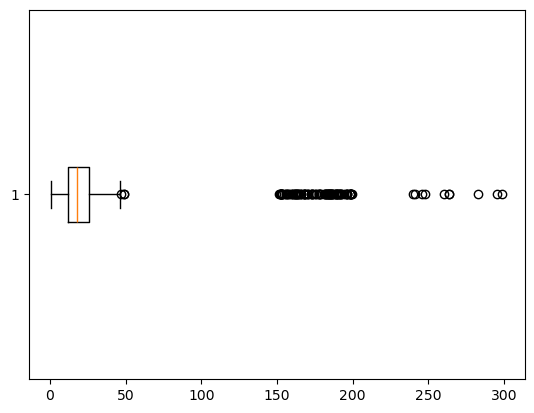

In [12]:
import matplotlib.pyplot as plt
plt.boxplot(df_augmented['pm2_5'], vert=False)
plt.show()

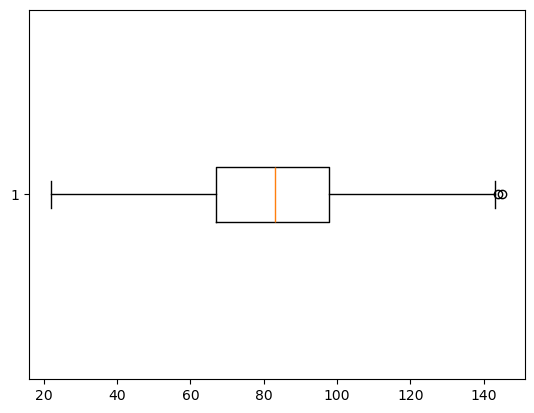

In [13]:
plt.boxplot(df_augmented['ozone'], vert=False)
plt.show()

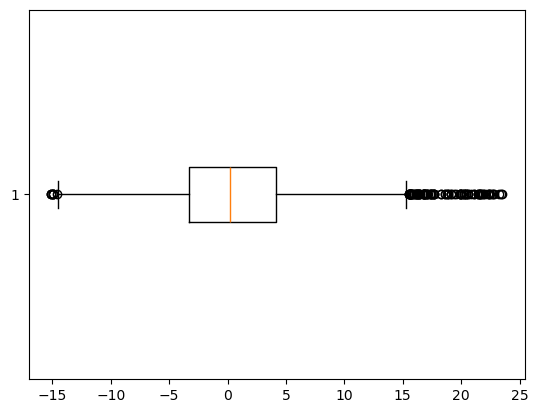

In [14]:
plt.boxplot(df_augmented['temperature_2m'], vert=False)
plt.show()

i see a lot of outliers, but they not really outliers. in a way that for example, ony my city Bishkek we had anti record, we had terrible air quality last few years, so i believe removing these "outliers" defeat the purpose of project, which is why instead i will remove only "not possible" values, like negative values or smth. 

In [15]:
negative = df_augmented[df_augmented['pm2_5'] < 0]
print(negative)

Empty DataFrame
Columns: [pm10, pm2_5, carbon_monoxide, nitrogen_dioxide, sulphur_dioxide, ozone, temperature_2m, relative_humidity_2m, wind_speed_10m, pressure_msl, city, elevation, datetime, hour, day_of_week, month, heating_season]
Index: []


In [16]:
print(df_augmented[df_augmented['carbon_monoxide'] < 0])

Empty DataFrame
Columns: [pm10, pm2_5, carbon_monoxide, nitrogen_dioxide, sulphur_dioxide, ozone, temperature_2m, relative_humidity_2m, wind_speed_10m, pressure_msl, city, elevation, datetime, hour, day_of_week, month, heating_season]
Index: []


In [17]:
print(df_augmented[df_augmented['nitrogen_dioxide'] < 0])
print(df_augmented[df_augmented['sulphur_dioxide'] < 0])
print(df_augmented[df_augmented['ozone'] < 0])

Empty DataFrame
Columns: [pm10, pm2_5, carbon_monoxide, nitrogen_dioxide, sulphur_dioxide, ozone, temperature_2m, relative_humidity_2m, wind_speed_10m, pressure_msl, city, elevation, datetime, hour, day_of_week, month, heating_season]
Index: []
Empty DataFrame
Columns: [pm10, pm2_5, carbon_monoxide, nitrogen_dioxide, sulphur_dioxide, ozone, temperature_2m, relative_humidity_2m, wind_speed_10m, pressure_msl, city, elevation, datetime, hour, day_of_week, month, heating_season]
Index: []
Empty DataFrame
Columns: [pm10, pm2_5, carbon_monoxide, nitrogen_dioxide, sulphur_dioxide, ozone, temperature_2m, relative_humidity_2m, wind_speed_10m, pressure_msl, city, elevation, datetime, hour, day_of_week, month, heating_season]
Index: []


In [18]:
print(df_augmented[df_augmented['temperature_2m'] < -100])
print(df_augmented[df_augmented['relative_humidity_2m'] < 0])
print(df_augmented[df_augmented['relative_humidity_2m'] > 100])
print(df_augmented[df_augmented['wind_speed_10m'] < 0])
print(df_augmented[df_augmented['pressure_msl'] < 800])

Empty DataFrame
Columns: [pm10, pm2_5, carbon_monoxide, nitrogen_dioxide, sulphur_dioxide, ozone, temperature_2m, relative_humidity_2m, wind_speed_10m, pressure_msl, city, elevation, datetime, hour, day_of_week, month, heating_season]
Index: []
Empty DataFrame
Columns: [pm10, pm2_5, carbon_monoxide, nitrogen_dioxide, sulphur_dioxide, ozone, temperature_2m, relative_humidity_2m, wind_speed_10m, pressure_msl, city, elevation, datetime, hour, day_of_week, month, heating_season]
Index: []
Empty DataFrame
Columns: [pm10, pm2_5, carbon_monoxide, nitrogen_dioxide, sulphur_dioxide, ozone, temperature_2m, relative_humidity_2m, wind_speed_10m, pressure_msl, city, elevation, datetime, hour, day_of_week, month, heating_season]
Index: []
Empty DataFrame
Columns: [pm10, pm2_5, carbon_monoxide, nitrogen_dioxide, sulphur_dioxide, ozone, temperature_2m, relative_humidity_2m, wind_speed_10m, pressure_msl, city, elevation, datetime, hour, day_of_week, month, heating_season]
Index: []
Empty DataFrame
Colu

Our target is pm2_5, all other columns are our features. I won't be using pm2_5 as feature because it is dominating among other features and defeat purpose of "learning model".

now, let's remove some columns - not needed, i will do so by using multicollinearity

In [19]:
df_augmented.columns

Index(['pm10', 'pm2_5', 'carbon_monoxide', 'nitrogen_dioxide',
       'sulphur_dioxide', 'ozone', 'temperature_2m', 'relative_humidity_2m',
       'wind_speed_10m', 'pressure_msl', 'city', 'elevation', 'datetime',
       'hour', 'day_of_week', 'month', 'heating_season'],
      dtype='object')

In [20]:
import seaborn as sns
columns1 = ['pm10', 'pm2_5', 'carbon_monoxide', 'nitrogen_dioxide',
       'sulphur_dioxide', 'ozone', 'temperature_2m', 'relative_humidity_2m',
       'wind_speed_10m', 'pressure_msl','datetime',
       'hour', 'day_of_week', 'month']

corr1 = df_augmented[columns1]

corr2 = corr1.select_dtypes(include='number')
print(corr2.corr())

                          pm10     pm2_5  carbon_monoxide  nitrogen_dioxide  \
pm10                  1.000000  0.722211         0.156432          0.281117   
pm2_5                 0.722211  1.000000        -0.069567          0.804131   
carbon_monoxide       0.156432 -0.069567         1.000000          0.269517   
nitrogen_dioxide      0.281117  0.804131         0.269517          1.000000   
sulphur_dioxide       0.245901  0.221701         0.446302          0.593358   
ozone                 0.111030 -0.298883         0.005869         -0.477986   
temperature_2m        0.196060 -0.069689        -0.391299         -0.231158   
relative_humidity_2m -0.213144  0.023546        -0.205407          0.085582   
wind_speed_10m       -0.037759 -0.254228        -0.383489         -0.271362   
pressure_msl         -0.222905 -0.163199         0.230264         -0.014261   
hour                  0.124977  0.120039         0.064132          0.247964   
day_of_week           0.004220 -0.009312        -0.0

In [21]:
df = df.drop('pm10', axis=1)

In [22]:
df.head()

,pm2_5,carbon_monoxide,nitrogen_dioxide,sulphur_dioxide,ozone,temperature_2m,relative_humidity_2m,wind_speed_10m,pressure_msl,city,elevation,datetime,hour,day_of_week,month,heating_season
0,5.6,451.0,3.3,4.0,75.0,4.0,66,8.1,1026.7,Bishkek,767,2024-11-01 00:00:00,0,4,11,1
1,5.8,514.0,3.8,5.2,76.0,4.9,64,6.2,1026.9,Bishkek,767,2024-11-01 01:00:00,1,4,11,1
2,6.5,582.0,4.5,6.8,76.0,4.0,68,6.9,1027.0,Bishkek,767,2024-11-01 02:00:00,2,4,11,1
3,7.7,592.0,4.8,7.8,79.0,6.8,62,4.1,1027.4,Bishkek,767,2024-11-01 03:00:00,3,4,11,1
4,8.8,489.0,4.2,7.7,84.0,9.0,56,6.0,1027.1,Bishkek,767,2024-11-01 04:00:00,4,4,11,1


In [23]:
# i will also remove elevation
df_augmented = df_augmented.drop('elevation', axis=1)

In [24]:
df_augmented = df_augmented.drop('city', axis=1)

In [25]:
# now, let's try detect collinearity between target and columns
# but, first multicollinearity
df_augmented = df_augmented.drop('heating_season', axis=1)

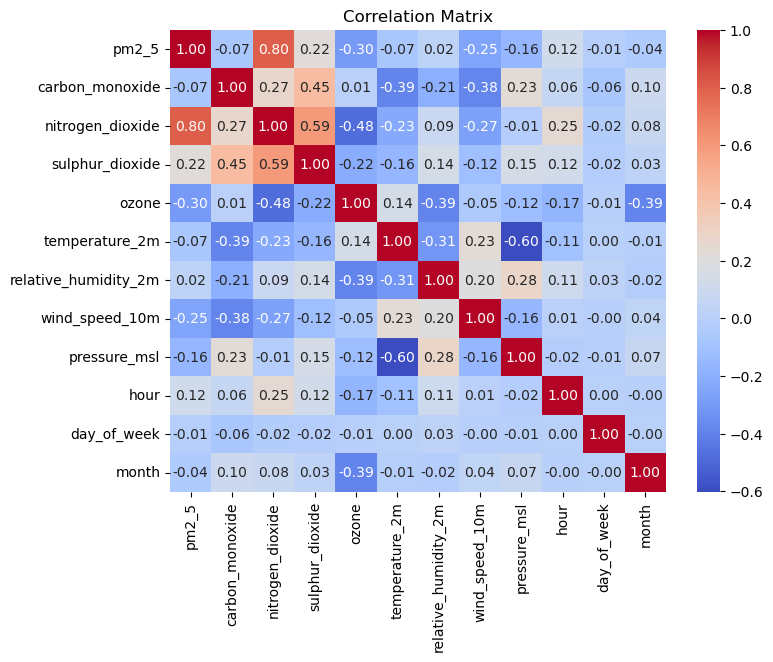

In [26]:
columns = ['pm2_5', 'carbon_monoxide', 'nitrogen_dioxide',
       'sulphur_dioxide', 'ozone', 'temperature_2m', 'relative_humidity_2m',
       'wind_speed_10m', 'pressure_msl', 'hour', 'day_of_week', 'month']

plt.figure(figsize=(8, 6))
sns.heatmap(df_augmented[columns].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [34]:
df_augmented.columns

Index(['pm2_5', 'carbon_monoxide', 'nitrogen_dioxide', 'sulphur_dioxide',
       'ozone', 'temperature_2m', 'relative_humidity_2m', 'wind_speed_10m',
       'pressure_msl', 'datetime', 'hour', 'day_of_week', 'month'],
      dtype='object')

df_augmented = df_augmented.drop('pm10', axis=1)

In [29]:
# now let's split the data
# nov-march (5 months)

X = df_augmented[['carbon_monoxide', 'nitrogen_dioxide', 'sulphur_dioxide', 'ozone', 
        'temperature_2m', 'relative_humidity_2m', 'wind_speed_10m', 'pressure_msl',
        'hour', 'day_of_week', 'month']]

y = df_augmented['pm2_5']  


In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [31]:
# let's do scaling and encoding
from sklearn.preprocessing import RobustScaler

contin = ['carbon_monoxide', 'nitrogen_dioxide', 'sulphur_dioxide', 'ozone', 
          'temperature_2m', 'relative_humidity_2m', 'wind_speed_10m', 'pressure_msl',
          'hour', 'day_of_week', 'month']

sc = RobustScaler()
x_train_num_sc = sc.fit_transform(X_train[contin])
x_val_num_sc = sc.transform(X_test[contin])

## Model Training

A regression model was trained to predict air quality metrics based on processed environmental features.

Model selection focused on stability and interpretability for real-world deployment.


In [32]:
# let's try some baseline model - randomforestclassifier 

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

model = RandomForestRegressor(
    n_estimators=400,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42
)
model.fit(x_train_num_sc, y_train)

preds = model.predict(x_val_num_sc)

print("mae: ", mean_absolute_error(y_test, preds))

# it gave me 3.6 mae, so baseline model is ready now we use xgboost with randomizedsearch

mae:  3.6528531580437953


In [33]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
import numpy as np

xgb = XGBRegressor(
    objective='reg:squarederror',
    random_state=42
)

param_dist = {
    'n_estimators': [500, 1000, 1500, 2000],
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.02, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.85, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.85, 0.9, 1.0],
    'min_child_weight': [1, 2, 3, 4],
    'reg_alpha': [0, 0.5, 1, 2],
    'reg_lambda': [1, 1.5, 2, 3]
}


rand_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=30,         
    scoring='neg_mean_absolute_error',
    cv=3,               
    verbose=2,
    random_state=42,
    n_jobs=-1          
)


rand_search.fit(x_train_num_sc, y_train)

best_model = rand_search.best_estimator_
print("Best MAE on CV:", -rand_search.best_score_)

preds = best_model.predict(x_val_num_sc)
mae_test = mean_absolute_error(y_test, preds)
print("Test MAE:", mae_test)


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best MAE on CV: 3.2561784008798527
Test MAE: 3.0779283214988475


## Model Evaluation

Model performance was evaluated using regression metrics, with Mean Absolute Error (MAE) used as the primary metric.


In [37]:
import pickle

# Suppose your trained model is called `model`
with open('xgb1_model.pkl', 'wb') as f:
    pickle.dump(model, f)


In [38]:
with open('scaler1.pkl', 'wb') as f:
    pickle.dump(sc, f)


## Deployment with Flask API

The trained model and preprocessing pipeline were integrated into a Flask API.

The API enables real-time prediction by accepting input features and returning air quality estimates.


## Conclusion

This project demonstrates a complete machine learning lifecycle:
- Data collection
- Preprocessing
- Modeling
- Evaluation
- Deployment

It reflects real-world challenges such as data variability and end-to-end system integration.
